In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from itertools import product
from math import log, atan
import ctypes
import pylab
from datetime import datetime
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
S = 10.
B = 8./3
R = 28
START = (1., 1., 1.)

In [3]:
T = 250.
dt = 5E-3
N = int(T/dt)
TIME_ = np.linspace(0, T, N)

In [4]:
def lorenz(x, y, z, r=R, s=S, b=B):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

In [5]:
def annotate(plt, text, arrow_to, text_pos):
    bbox = {
    'boxstyle': 'round,pad=1',
    'fc': 'yellow',
    'alpha': 0.5
    }
    arrow = {
        'arrowstyle': '->',
        'connectionstyle': 'arc3,rad=0'
    }
    return plt.annotate(text,
                        xy=arrow_to,
                        xytext=text_pos,
                        bbox=bbox,
                        arrowprops=arrow)

In [6]:
xs_ = np.empty_like(TIME_)
ys_ = np.empty_like(TIME_)
zs_ = np.empty_like(TIME_)
xs_[0], ys_[0], zs_[0] = START

In [7]:
for i in range(len(TIME_) - 1):
    dx, dy, dz = lorenz(xs_[i], ys_[i], zs_[i])
    xs_[i+1] = xs_[i] + dx * dt
    ys_[i+1] = ys_[i] + dy * dt
    zs_[i+1] = zs_[i] + dz * dt

In [8]:
phase_volume = xs_ * ys_ * zs_
global_min = phase_volume.argmin()
local_max = np.argwhere(phase_volume[global_min:-1] - phase_volume[global_min+1:] > 0)[0][0]
local_flat = np.argwhere(phase_volume[local_max:-1] - phase_volume[local_max+1:] > 0)[0][0]
T_INI = global_min + local_max + local_flat

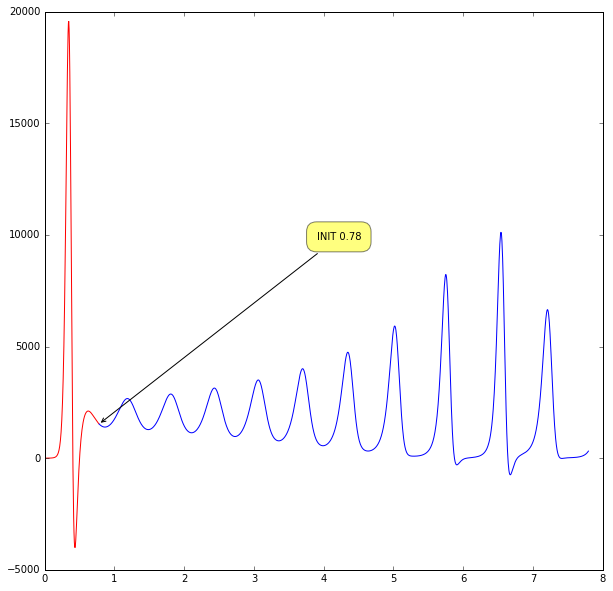

In [9]:
volume_intervals = T_INI*10
volume_time = TIME_[:volume_intervals]
plt.plot(volume_time[:T_INI], phase_volume[:T_INI], 'r')
plt.plot(volume_time[T_INI:], phase_volume[T_INI:volume_intervals])

annotate(plt, 'INIT %4.2f'%TIME_[T_INI],
         (TIME_[T_INI], phase_volume[T_INI]), (volume_time.max()/2, phase_volume.max()/2))
plt.show()

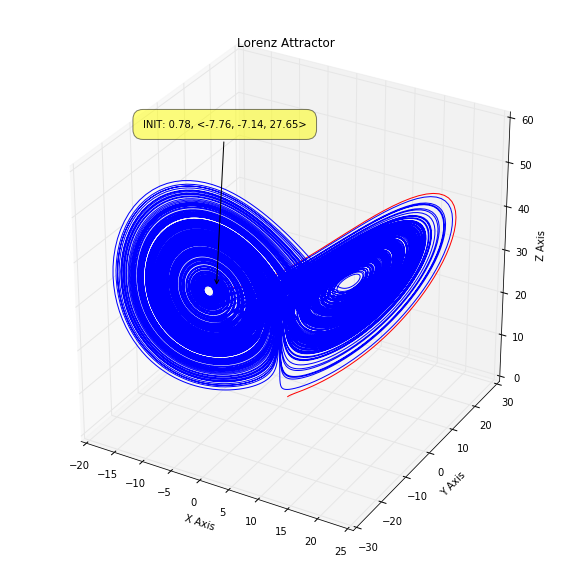

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs_[:T_INI], ys_[:T_INI], zs_[:T_INI], 'r')
ax.plot(xs_[T_INI:], ys_[T_INI:], zs_[T_INI:])
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

x_ini, y_ini, _ = proj3d.proj_transform(xs_[T_INI], ys_[T_INI], zs_[T_INI], ax.get_proj())
annotate(plt, 'INIT: {:4.2f}, <{:4.2f}, {:4.2f}, {:4.2f}>'.format(TIME_[T_INI], xs_[T_INI], ys_[T_INI], zs_[T_INI]),
         (x_ini, y_ini), (-0.05, .05))

plt.show()

In [11]:
xs, ys, zs, TIME = xs_[T_INI:], ys_[T_INI:], zs_[T_INI:], TIME_[T_INI:]
N_MAX = N - T_INI
assert len(xs) == N_MAX and len(ys) == N_MAX and len(xs) == N_MAX

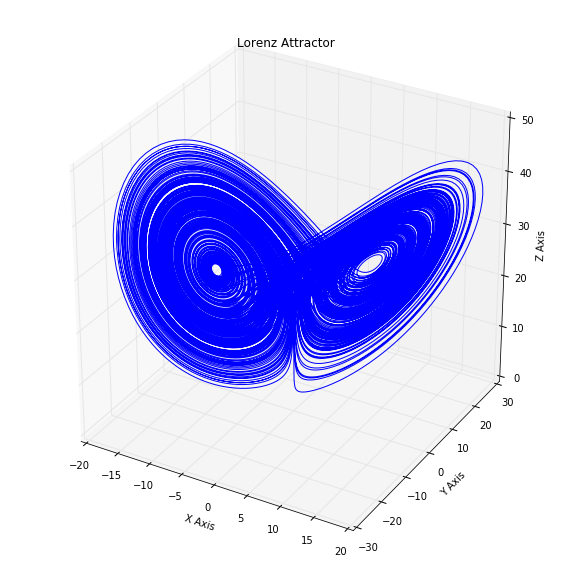

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [13]:
def R(t, sequence):
    if t == 0:
        seq1 = sequence[:]
    else:
        seq1 = sequence[:-t]
    seq2 = sequence[t:]
    return (seq1 * seq2).mean()

In [14]:
autocorr = [np.array([R(t, s) for t in range(int(N_MAX/100))]) for s in (xs, ys, zs)]
local_tau_min = [np.argwhere(s[:-1] - s[1:] < 0)[0][0] for s in autocorr]

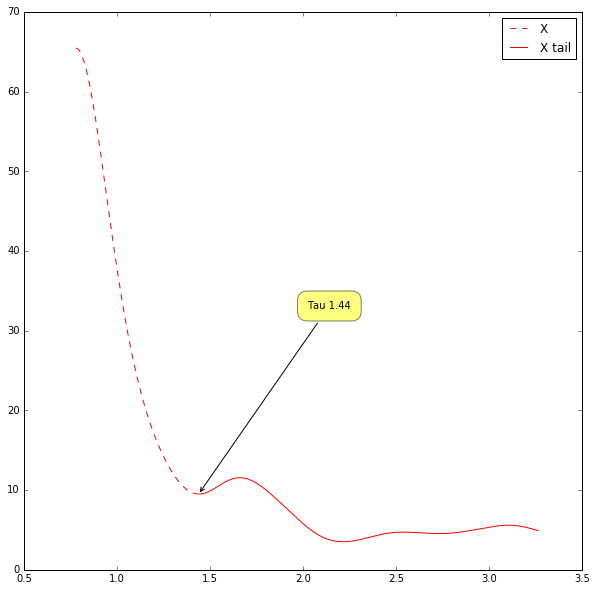

In [15]:
TAU_ = local_tau_min[0]
end = min(local_tau_min[0]*10, len(autocorr[0]))
graphical_info = (('r', 'X'), ('g', 'Y'), ('b', 'Z'))
for lm, ac, g in zip(local_tau_min[:1], autocorr[:1], graphical_info[:1]):
    plt.plot(TIME[:lm], ac[:lm], g[0] + '--', label=g[1])
    plt.plot(TIME[lm:end], ac[lm:end], g[0], label='%s tail'%g[1])

annotate(plt, 'Tau %4.2f'%TIME[TAU_], (TIME[local_tau_min[0]], autocorr[0][local_tau_min[0]]), (TIME[int(end/2)], max(autocorr[0])/2))
plt.legend()
plt.show()

In [16]:
result = []
rng = [(1E-2)*i for i in range(100, 0, -1)]
for i in rng:
    tau = int(TAU_*i)
    fin = -tau*2
    if fin == 0:
        break
    ideal = (xs[:fin], ys[:fin], zs[:fin])
    result.append([((seq - d)**2).sum()/(N_MAX-tau*2) for seq, d in zip((xs[:-tau*2], xs[tau:-tau], xs[tau*2:]), ideal)])
result = np.array(result)
rng = np.array(rng[:len(result)])
result_y = result[:, 1]
result_z = result[:, 2]
local_min = np.argwhere(result_y[:-1] - result_y[1:] < 0)[0][0]
TAU = int(TAU_ * rng[local_min]*1.2)

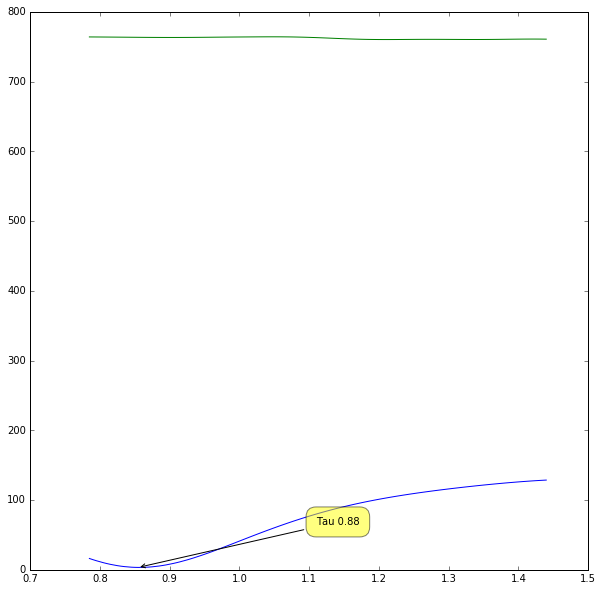

In [17]:
plt.plot(TIME[(rng*TAU_).astype('i')], result_y)
plt.plot(TIME[(rng*TAU_).astype('i')], result_z)
annotate(plt, 'Tau %4.2f'%TIME[TAU], (TIME[int(TAU_*rng[local_min])], result_y[local_min]), (TIME[int(TAU_*max(rng)/2)], max(result_y)/2))
plt.show()

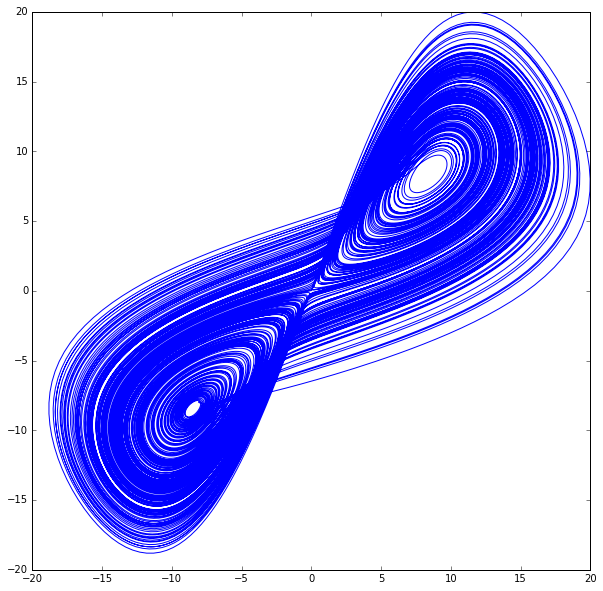

In [18]:
plt.plot(xs[:-TAU*2], xs[TAU:-TAU])
plt.show()

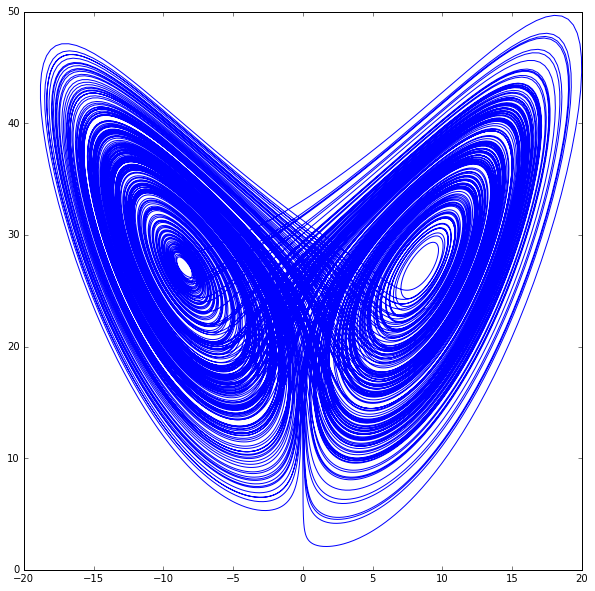

In [19]:
plt.plot(xs, zs)
plt.show()

In [20]:
N_FINAL = N_MAX - int(2*TIME[TAU] / dt)
ns = np.array(list(range(0, N_FINAL+1)))
Y = xs[ns], xs[ns+TAU], xs[ns+2*TAU]

In [21]:
cor = ctypes.cdll.LoadLibrary('./lib_corellation.so')
def C(r, seq, n=None, dim=1, results=None):
    if n is None:
        n = len(seq[0])
    start = datetime.now()
    # return (np.array([np.abs(seq[0][j] - seq[0][k]) for j, k in product(range(n), range(n))]) < r).sum() / (n**2)
    if dim == 1:
        result = cor.cor(r, seq[0].astype('double').ctypes.get_as_parameter(), n) * 2 / (n**2.)
    elif dim == 2:
        result = cor.cor2(r, seq[0].astype('double').ctypes.get_as_parameter(), seq[1].astype('double').ctypes.get_as_parameter(), n) * 2 / (n**2.)
    elif dim == 3:
        result = cor.cor3(r, seq[0].astype('double').ctypes.get_as_parameter(), seq[1].astype('double').ctypes.get_as_parameter(), seq[2].astype('double').ctypes.get_as_parameter(), n) * 2 / (n**2.)
    else:
        assert False
    t = datetime.now() - start
    print('{}: calculate for {} dimensions on r={} ({} elements): {}'.format(t.seconds, dim, r, n, result))
    return result

In [22]:
# R1, R2, R3 = np.empty(10), np.empty(10), np.empty(10)
# R1 = [C(r, Y, dim=1) for r in range(1, 11)]
R2 = [C(r, Y, dim=2) for r in range(1, 11)]
# R3 = [C(r, Y, dim=3) for r in range(1, 11)]

11: calculate for 2 dimensions on r=1 (49495 elements): 0.04795046557767547
11: calculate for 2 dimensions on r=2 (49495 elements): 0.09553774381991521
11: calculate for 2 dimensions on r=3 (49495 elements): 0.1425789356223486
11: calculate for 2 dimensions on r=4 (49495 elements): 0.18890444280239818
11: calculate for 2 dimensions on r=5 (49495 elements): 0.23443091253583612
11: calculate for 2 dimensions on r=6 (49495 elements): 0.2790997528416132
11: calculate for 2 dimensions on r=7 (49495 elements): 0.32275747082098544
11: calculate for 2 dimensions on r=8 (49495 elements): 0.3653611536116759
11: calculate for 2 dimensions on r=9 (49495 elements): 0.40669195892352544
11: calculate for 2 dimensions on r=10 (49495 elements): 0.4466742375597331


In [23]:
e2 = '''
R1, R2, R3 = ([0.06858820090271134,
  0.13604961519518127,
  0.20172328455576566,
  0.26494029946370573,
  0.32533073246144256,
  0.38278514723383616,
  0.4372429768968891,
  0.4887405413398031,
  0.5375513872768549,
  0.5837147499825097],
 [0.048611680723505774,
  0.09672777370223277,
  0.14415715796596026,
  0.19065215962035978,
  0.23594768101841349,
  0.27989235718547406,
  0.3223902513787026,
  0.36342076654812383,
  0.4029582290210472,
  0.4409904222558644],
 [0.04862133120372874,
  0.09674382627708268,
  0.1441788160464065,
  0.19067535537881178,
  0.23596821930362413,
  0.27991255594093395,
  0.32240370850978484,
  0.3634253436703405,
  0.40295397836974467,
  0.4409757343294357])
'''

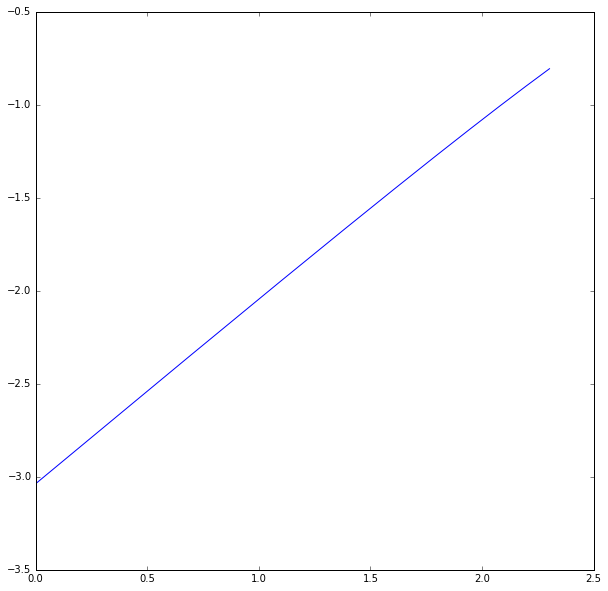

In [24]:
rs = list(range(1, 11))
plt.plot([log(r) for r in rs], [log(r) for r in R2])
plt.show()

In [25]:
rmin, rmax = min(log(r) for r in rs), max(log(r) for r in rs)

In [26]:
Rs = [log(r) for r in R2]
Rmin, Rmax = min(Rs), max(Rs)
(Rmax - Rmin) / (rmax - rmin)

0.9691980764370113

In [27]:
[(Rs[i+1]-Rs[i])/(log(rs[i+1])-log(rs[i])) for i in range(len(rs)-1)]

[0.9945259838803979,
 0.9874447390851009,
 0.9779737424459072,
 0.9676265954762592,
 0.9565973965295186,
 0.9427913131972874,
 0.9285093718342738,
 0.9098909215978893,
 0.890025187413446]

In [28]:
atan(2.06)

1.1188669313964847